# Store locations
*__Finding the optimal location for a low-cost supermarket in Madrid__*

## Table of Contents

* [Introduction](#introduction)
    * [Background](#background)
    * [Business problem](#business-problem)
* [Data](#data)
    * [Wikipedia](#wikipedia)
    * [Geospatial data](#geospatial-data)
    * [Census data](#census-data)
* [Methodology](#methodology)
    * [Data acquisition](#data-acquisition)
        * [Scrapping Wikipedia](#scrapping-wikipedia)
        * [Requesting Foursquare API for geospatial data](#requesting-foursquare)
        * [Loading census data file](#loading-census)
    * [Neighbourhood segmentation](#neighbourhood-segmentation)
    * [Census analysis](#census-analysis)
* [Results and discussion](#results-and-discussion)
* [Conclusion](#conclusion)

## Introduction <a class="anchor" id="introduction"></a>

### Background <a class="anchor" id="background"></a>

Opening a physical store is not without risks. One the most obvious risks to evaluate before opening a new store is receiving enough customers to make the business profitable. Therefore it is essential to pick the right location to make sure it is convenient for the customers and there is enough demand for a new store in the area.

Identifying the target customers is also key taking into account the behaviour of the different groups of consumers and the stores they usually buy at.

### Business problem <a class="anchor" id="business-problem"></a>

In this project, we tackle the problem of a low-cost supermarket chain trying to decide in which area of Madrid (Spain) they should open their new store in order to maximise the revenue. It is important to note that the city of Madrid consists of 21 districts and 131 neighbourhoods with great differences between them. 

The goal is to identify the optimal neighbourhood for opening a store taking different factors into consideration such as the types of neighbourhood (a residential area would be ideal), the amount of people living in those areas (the higher the population the higher the food demand), their average income (working class people are preferred) and the stores that are already available (avoiding areas with a big density of supermarkets).

Using data science, geospatial analysis and machine learning techniques, this project aims to provide a solution for this problem and recommending the best neighbourhood for opening the low-cost supermarket.

## Data <a class="anchor" id="data"></a>

The following sections describe the data that is needed for answering this business question.

### Wikipedia <a class="anchor" id="wikipedia"></a>

The first data that we need is the list of neighbourhoods in Madrid. Even though this information could have been directly obtained from a CSV file from Madrid city council, it has been decided to use web scraping on Wikipedia for learning purposes.

The Wikipedia page “List of neighbourhoods of Madrid” shows a table with the name of each neighbourhood for each of the 21 districts. In our project, we will work directly with the neighbourhoods and ignore the districts since this way we can perform a more granular analysis of the areas.

<p align="center">
  <img width="500" height="500" src="img/wikipedia_madrid.png">
</p>

<p style="text-align: center;">
    Source: 
    <a href="https://en.wikipedia.org/wiki/List_of_neighborhoods_of_Madrid">https://en.wikipedia.org/wiki/List_of_neighborhoods_of_Madrid</a>
</p>

### Geospatial data <a class="anchor" id="geospatial-data"></a>

Since the plan is to target residential areas, we need to analyse the type of food venues present in each neighbourhood. With the Foursquare API we can explore the different food venues, considering that a big density of bars and restaurants over very few supermarkets will most likely refer to a business or recreational area where people don’t usually buy at supermarkets. In the other hand, a large proportion of supermarkets over the rest of food venues might indicate it is a residential area where people normally make their food shopping.

Before we can make use of the Foursquare API we need to convert the neighbourhood names into a pair of latitude and longitude coordinates. We can acquire this with the _geocoder_ Python library.
We can query the Foursquare API using the HTTP GET method on the explore endpoint indicating the geographical coordinates, venue categories and radius.

<p align="center">
  <img width="500" height="500" src="img/foursquare_api.png">
</p>

<p style="text-align: center;">
    Source: 
    <a href="https://developer.foursquare.com/docs/api-reference/venues/explore/">https://developer.foursquare.com/docs/api-reference/venues/explore/</a>
</p>

### Census data <a class="anchor" id="census-data"></a>

Finally we will need data from the census of Madrid. We can obtained this data from Excel files that are accessible from the Madrid city council website. Particularly we are interested in the population and the average income of each neighbourhood.

<p align="center">
  <img width="500" height="500" src="img/census_population.png">
</p>

<p style="text-align: center;">
    Source: 
    <a href="http://www-2.munimadrid.es/TSE6/control/seleccionDatosBarrio">http://www-2.munimadrid.es/TSE6/control/seleccionDatosBarrio</a>
</p>

<p align="center">
  <img width="500" height="500" src="img/census_income.png">
</p>

<p style="text-align: center;">
    Source: 
    <a href="https://datos.madrid.es/portal/site/egob/menuitem.c05c1f754a33a9fbe4b2e4b284f1a5a0/?vgnextoid=d029ed1e80d38610VgnVCM2000001f4a900aRCRD&vgnextchannel=374512b9ace9f310VgnVCM100000171f5a0aRCRD&vgnextfmt=default">https://datos.madrid.es/portal/site/egob</a>
</p>

## Methodology <a class="anchor" id="methodology"></a>

The following sections describe the different stages of this project, starting with the acquisition of the data (venues and census), following with the clustering of the neighbourhoods and finishing with an analysis of the census for the corresponding group of neighbourhoods.

### Libraries import

In [840]:
# for HTTP requests
import requests  

# for HTML scrapping 
from bs4 import BeautifulSoup 

# for table analysis
import pandas as pd
import numpy as np

# for finding geographical coordinates
!pip install geocoder
import geocoder

# for converting an address into latitude and longitude values
from geopy.geocoders import Nominatim

# for rending maps
import folium

# for removing Spanish accents from map labels in Folium (encoding incompatibility)
import unicodedata

# for clustering neighbourhoods
from sklearn.cluster import KMeans

# for drawing the elbow method and scatterplot
import matplotlib.pyplot as plt

# for displaying map of clusters
import matplotlib.cm as cm
import matplotlib.colors as colors

# for displaying the scatterplot of household income vs people per market
import seaborn as sns

### Data acquisition <a class="anchor" id="data-acquisition"></a>

The following sub-sections describe the methodology to obtain the different datasets, either by loading an external file or by scrapping a website.

#### Scrapping Wikipedia <a class="anchor" id="scrapping-wikipedia"></a>

__URL for Wikipedia article__

In [752]:
# URL of wikipedia page from which to scrap tabular data.
wiki_url = "https://en.wikipedia.org/wiki/List_of_neighborhoods_of_Madrid"

__Request & Response__

In [753]:
# If the request was successful, reponse should be '200'.
response = requests.get(wiki_url) #.json()
response

<Response [200]>

__Wrangling HTML With BeautifulSoup__

In [754]:
# Parse response content to html
soup = BeautifulSoup(response.content, 'html.parser')
#soup

__Viewing HTML content__

In [755]:
# Title of Wikipedia page
title = soup.title.string
print(f'Page title: {title}') 

# Find the right table to scrap
wiki_table=soup.find('table', {"class":'wikitable sortable'})

# Get the 1st row of the table i.e. the header
row0 = wiki_table.findAll("tr")[0]

# Show the column names (we're only interested in "Name" i.e. the 4th column)
header = [th.text.rstrip() for th in row0.find_all('th')]
print(f'Column names: {header}') 

Page title: List of neighborhoods of Madrid - Wikipedia
Column names: ['District name (number)', 'District location', 'Number', 'Name', 'Image']


__Scraping the table contents__

In [756]:
# Placeholder for list of neighbourhoods
madrid_neighbourhoods = []

# Iterate through the rows of the table
# Note: each district has sub-rows of neighbourhoods
for row in wiki_table.findAll("tr"):    
    cells = row.findAll('td')

    # Parse 1st neighbourhood of the district
    if len(cells)==5:
        madrid_neighbourhoods.append(cells[3].find(text=True).replace('\n', '').rstrip().lstrip().upper())
    
    # Parse sub-rows (rest of neighbourhoods of the district)
    elif len(cells)==3:
        madrid_neighbourhoods.append(cells[1].find(text=True).replace('\n', '').rstrip().lstrip().upper())
    
print(f'Number of neighbourhoods: {len(madrid_neighbourhoods)}')
madrid_neighbourhoods

Number of neighbourhoods: 131


['PALACIO',
 'EMBAJADORES',
 'CORTES',
 'JUSTICIA',
 'UNIVERSIDAD',
 'SOL',
 'IMPERIAL',
 'ACACIAS',
 'CHOPERA',
 'LEGAZPI',
 'DELICIAS',
 'PALOS DE MOGUER',
 'ATOCHA',
 'PACÍFICO',
 'ADELFAS',
 'ESTRELLA',
 'IBIZA',
 'LOS JERÓNIMOS',
 'NIÑO JESÚS',
 'RECOLETOS',
 'GOYA',
 'FUENTE DEL BERRO',
 'GUINDALERA',
 'LISTA',
 'CASTELLANA',
 'EL VISO',
 'PROSPERIDAD',
 'CIUDAD JARDÍN',
 'HISPANOAMÉRICA',
 'NUEVA ESPAÑA',
 'CASTILLA',
 'BELLAS VISTAS',
 'CUATRO CAMINOS',
 'CASTILLEJOS',
 'ALMENARA',
 'VALDEACEDERAS',
 'BERRUGUETE',
 'GAZTAMBIDE',
 'ARAPILES',
 'TRAFALGAR',
 'ALMAGRO',
 'RÍOS ROSAS',
 'VALLEHERMOSO',
 'EL PARDO',
 'FUENTELARREINA',
 'PEÑAGRANDE',
 'PILAR',
 'LA PAZ',
 'VALVERDE',
 'MIRASIERRA',
 'EL GOLOSO',
 'CASA DE CAMPO',
 'ARGÜELLES',
 'CIUDAD UNIVERSITARIA',
 'VALDEZARZA',
 'VALDEMARÍN',
 'EL PLANTÍO',
 'ARAVACA',
 'LOS CÁRMENES',
 'PUERTA DEL ÁNGEL',
 'LUCERO',
 'ALUCHE',
 'CAMPAMENTO',
 'CUATRO VIENTOS',
 'LAS ÁGUILAS',
 'COMILLAS',
 'OPAÑEL',
 'SAN ISIDRO',
 'VISTA ALEGR

__Creating a dataframe__

In [757]:
df_madrid = pd.DataFrame(madrid_neighbourhoods, columns=['Neighbourhood'])
print(f'Shape: {df_madrid.shape}')
df_madrid.head()

Shape: (131, 1)


,Neighbourhood
0,PALACIO
1,EMBAJADORES
2,CORTES
3,JUSTICIA
4,UNIVERSIDAD


In [758]:
##################################################################################################################################
# DUMMY
radius = 1000
#df_madrid = df_madrid[df_madrid['Neighbourhood'].isin(['Valdefuentes', 'Sol'])]  #.sample(frac=0.1)
#df_madrid = df_madrid.sample(frac=0.1)
##################################################################################################################################

__Getting geographical coordinates for the neighbourhoods__

In [877]:
# Geocoder fails to locate some of the neighbourhoods correctly and therefore it is necessary
# to request the coordinates using a different name for these particular areas.
def rename(neighbourhood):
    new_name = neighbourhood
    if new_name == 'CASCO HISTÓRICO DE VICÁLVARO':
        new_name = 'VICÁLVARO'
    elif new_name == 'QUINTANA':
        new_name = 'PARQUE DE CALERO'
    elif new_name == 'BUTARQUE':
        new_name = 'VILLAVERDE BAJO'
    return new_name

# Function that retrieves the geographical coordinates for a given neighborhood
def get_coordinates(row):
    # initialize variable to None
    lat_lng_coords = None

    # loop until we get the coordinates
    while(lat_lng_coords is None):
      g = geocoder.arcgis(f'{rename(row["Neighbourhood"])}, Madrid')
      lat_lng_coords = g.latlng
    
    # return pair lat,long
    return pd.Series([lat_lng_coords[0], lat_lng_coords[1]])

In [878]:
# Fill coordinates for each row
df_madrid[['Latitude','Longitude']] = df_madrid.apply(get_coordinates, axis=1)
df_madrid.head()

,Neighbourhood,Latitude,Longitude
0,PALACIO,40.41517,-3.71273
1,EMBAJADORES,40.40803,-3.70067
2,CORTES,40.41589,-3.69636
3,JUSTICIA,40.42479,-3.69308
4,UNIVERSIDAD,40.42565,-3.70726


In [761]:
# Make sure we found the coordinates for all the neighbourhoods
df_madrid.isnull().sum()

Neighbourhood    0
Latitude         0
Longitude        0
dtype: int64

__Visualizing the neighbourhoods of Madrid__

In [762]:
address = 'Madrid, Spain'
geolocator = Nominatim(user_agent="madrid_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(f'The geograpical coordinates of Madrid are {latitude}, {longitude}')

The geograpical coordinates of Madrid are 40.4167047, -3.7035825


In [763]:
# Spanish accents are not correctly rendered in the map labels so we decided
# to remove them for a better understanding of the map
def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    only_ascii = nfkd_form.encode('ASCII', 'ignore')
    return only_ascii.decode("utf-8")

In [764]:
# create map of Madrid using latitude and longitude values
map_madrid = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(df_madrid['Latitude'], df_madrid['Longitude'], df_madrid['Neighbourhood']):
    label = folium.Popup(remove_accents(label), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_madrid)  
    
map_madrid

#### Requesting Foursquare API for geospatial data <a class="anchor" id="requesting-foursquare"></a>

In [765]:
CLIENT_ID = 'BHJXSXUIL3QMVG5D40DTXTROBNKAMXXYNZSISUHVXAL3HXZO' # Foursquare ID
CLIENT_SECRET = 'FRLBLH40G0T4OWROEXCQU3MY35OZAIE3HXJ5J1X02RXNMTWP' # Foursquare Secret
ACCESS_TOKEN = 'N1LDGNZGUPHICQM1Y5LRR5RMQGULD1MLDZQIISPLTI0CL4I0' # FourSquare Access Token
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)
print('ACCESS_TOKEN:' + ACCESS_TOKEN)

Credentails:
CLIENT_ID: BHJXSXUIL3QMVG5D40DTXTROBNKAMXXYNZSISUHVXAL3HXZO
CLIENT_SECRET:FRLBLH40G0T4OWROEXCQU3MY35OZAIE3HXJ5J1X02RXNMTWP
ACCESS_TOKEN:N1LDGNZGUPHICQM1Y5LRR5RMQGULD1MLDZQIISPLTI0CL4I0


In [766]:
# Foursquare category IDs defined here: https://developer.foursquare.com/docs/build-with-foursquare/categories/
food_restaurants = '4d4b7105d754a06374d81259'
food_drink_stores = '4bf58dd8d48988d1f9941735'
schools = '4bf58dd8d48988d13b941735'
categories = food_restaurants + ',' + food_drink_stores + ',' + schools

In [767]:
##########################################################################################
# To Do:
# merge all types of restaurante-categories into 1 category named 'Restaurant',
# since for our analysis we are not interesting in the types of restaurant.
# Hint: if v['venue']['categories'][0]['name'].contains('Restaurant') then 'Restaurant'

In [768]:
# Function to merge all the restaurant-like categories into one category named 'Restaurant',
# and all the market-like shops into another category,
# since for our analysis we are not interested in the type of restaurant or market.
market_categories = ['Supermarket', 'Market', 'Farmers Market', 'Grocery Store', 'Big Box Store', 'Convenience Store', 'Food & Drink Shop']
def parseCategory(category):
    if 'Restaurant' in category or 'Burger' in category or 'BBQ' in category or 'Sandwich' in category or 'Pizza' in category:
        category = 'Restaurant'
    elif 'Bar' in category or 'Pub' in category or 'pub' in category or 'Joint' in category:
        category = 'Bar'
    elif 'Coffee' in category or 'Café' in category or 'Diner' in category or 'Breakfast Spot' in category:
        category = 'Coffee Shop'
    elif category in market_categories:
        category = 'Market'
    return category

# Function to find venues in a given neighbourhood
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['venues']

        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['name'], 
            v['location']['lat'], 
            v['location']['lng'],  
            v['categories'][0]['name']) for v in results if v['categories']]) # parseCategory()

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

__Run the above function to each neighbourhood__

In [769]:
madrid_venues = getNearbyVenues(names=df_madrid['Neighbourhood'],
                                   latitudes=df_madrid['Latitude'],
                                   longitudes=df_madrid['Longitude'],
                                   radius=radius)

print(madrid_venues.shape)
madrid_venues.head()

(11915, 7)


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,PALACIO,40.41517,-3.71273,Cervecería La Mayor,40.415218,-3.712194,Beer Bar
1,PALACIO,40.41517,-3.71273,Santa Iglesia Catedral de Santa María la Real ...,40.415767,-3.714516,Church
2,PALACIO,40.41517,-3.71273,Instituto Italiano de Cultura,40.415197,-3.712883,General College & University
3,PALACIO,40.41517,-3.71273,Iglesia Catedral de las Fuerzas Armadas,40.415114,-3.712331,Church
4,PALACIO,40.41517,-3.71273,Consejo De Estado,40.415129,-3.713384,Government Building


__Analysing each neighbourhood__

In [770]:
# one hot encoding
madrid_onehot = pd.get_dummies(madrid_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighbourhood column back to dataframe
madrid_onehot['Neighbourhood'] = madrid_venues['Neighbourhood'] 

# move neighbourhood column to the first column
fixed_columns = [madrid_onehot.columns[-1]] + list(madrid_onehot.columns[:-1])
madrid_onehot = madrid_onehot[fixed_columns]

print(f'Size: {madrid_onehot.shape}')
madrid_onehot.head()

Size: (11915, 503)


,Neighbourhood,Accessories Store,Acupuncturist,Adult Boutique,Adult Education Center,Advertising Agency,African Restaurant,Airport,Airport Gate,Airport Lounge,...,Well,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,PALACIO,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,PALACIO,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,PALACIO,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,PALACIO,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,PALACIO,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


__Grouping rows by neighbourhood and finding frequency of each category__

In [771]:
madrid_grouped = madrid_onehot.groupby('Neighbourhood').mean().reset_index()
print(f'Size: {madrid_grouped.shape}')
madrid_grouped

Size: (131, 503)


,Neighbourhood,Accessories Store,Acupuncturist,Adult Boutique,Adult Education Center,Advertising Agency,African Restaurant,Airport,Airport Gate,Airport Lounge,...,Well,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,ABRANTES,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00
1,ACACIAS,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.010417,0.010417,0.000000,0.000000,0.000000,0.00,0.00
2,ADELFAS,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00
3,AEROPUERTO,0.032787,0.000000,0.000000,0.000000,0.000000,0.000000,0.016393,0.540984,0.016393,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00
4,ALAMEDA DE OSUNA,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00
5,ALMAGRO,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00
6,ALMENARA,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00
7,ALMENDRALES,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.010204,0.000000,0.000000,0.000000,0.00,0.00
8,ALUCHE,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.010204,0.000000,0.000000,0.010204,0.000000,0.000000,0.000000,0.00,0.00
9,AMPOSTA,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00


__Most common types of venue in each neighbourhood__

In [772]:
# Only show the 5 most common categories
num_top_venues = 5

for neighbourhood in madrid_grouped['Neighbourhood']:
    print("----"+neighbourhood+"----")
    temp = madrid_grouped[madrid_grouped['Neighbourhood'] == neighbourhood].T.reset_index()
    temp.columns = ['Venue','Frequency']
    temp = temp.iloc[1:]
    temp['Frequency'] = temp['Frequency'].astype(float)
    temp = temp.round({'Frequency': 2})
    print(temp.sort_values('Frequency', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----ABRANTES----
                  Venue  Frequency
0                   Bar       0.07
1                  Bank       0.04
2    Salon / Barbershop       0.04
3      Dentist's Office       0.03
4  Gym / Fitness Center       0.03


----ACACIAS----
                Venue  Frequency
0  Salon / Barbershop       0.06
1                Bank       0.05
2          Non-Profit       0.05
3                Park       0.05
4      Medical Center       0.03


----ADELFAS----
                                      Venue  Frequency
0                                    Office       0.07
1  Residential Building (Apartment / Condo)       0.05
2                                  Pharmacy       0.04
3                                      Bank       0.04
4                                       Bar       0.03


----AEROPUERTO----
                 Venue  Frequency
0         Airport Gate       0.54
1      Airport Service       0.08
2      Coworking Space       0.03
3  Rental Car Location       0.03
4    Accessories S

#### Loading census data file<a class="anchor" id="loading-census"></a>

__Population by neighbourhood__

In [800]:
# Load data from file taking into account the table headers are on the 4th row and the population need to be converted to integer.
df_madrid_population = pd.read_excel('files/madrid_population.xls', header=3, names=['District', 'Neighbourhood', 'Population'], nrows=131, converters={'Total': int})
print(df_madrid_population.shape)
df_madrid_population.head()

(131, 3)


,District,Neighbourhood,Population
0,CENTRO,PALACIO,23691
1,CENTRO,EMBAJADORES,47460
2,CENTRO,CORTES,10763
3,CENTRO,JUSTICIA,18179
4,CENTRO,UNIVERSIDAD,33527


In [801]:
# Drop District column
df_madrid_population.drop('District', axis=1, inplace=True)
print(df_madrid_population.shape)
df_madrid_population.head()

(131, 2)


,Neighbourhood,Population
0,PALACIO,23691
1,EMBAJADORES,47460
2,CORTES,10763
3,JUSTICIA,18179
4,UNIVERSIDAD,33527


__Household income by neighbourhood__

In [802]:
# Load data from file taking into account the table headers are on the 4th row and the population need to be converted to integer.
df_madrid_income = pd.read_excel('files/madrid_income.xlsx', names=['District', 'Neighbourhood', 'Income'], converters={'Income': int})
print(df_madrid_income.shape)
df_madrid_income.head()

(131, 3)


,District,Neighbourhood,Income
0,01. Centro,011. Palacio,34675
1,01. Centro,012. Embajadores,25999
2,01. Centro,013. Cortes,34952
3,01. Centro,014. Justicia,40314
4,01. Centro,015. Universidad,30701


In [803]:
# Drop District column and remove digits from Neighbourhood column
df_madrid_income.drop('District', axis=1, inplace=True)
df_madrid_income['Neighbourhood'] = df_madrid_income['Neighbourhood'].str[8:].str.upper()
print(df_madrid_income.shape)
df_madrid_income.head()

(131, 2)


,Neighbourhood,Income
0,PALACIO,34675
1,EMBAJADORES,25999
2,CORTES,34952
3,JUSTICIA,40314
4,UNIVERSIDAD,30701


### Neighbourhood segmentation <a class="anchor" id="neighbourhood-segmentation"></a>

__Converting into a Dataframe__

In [776]:
# Function for sorting the venues in descencing order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [777]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = madrid_grouped['Neighbourhood']

for ind in np.arange(madrid_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(madrid_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ABRANTES,Bar,Salon / Barbershop,Bank,Gym / Fitness Center,Dentist's Office,Beer Garden,Church,Bakery,Ice Cream Shop,Residential Building (Apartment / Condo)
1,ACACIAS,Salon / Barbershop,Bank,Park,Non-Profit,Pizza Place,Medical Center,Pub,Tapas Restaurant,Fruit & Vegetable Store,Garden
2,ADELFAS,Office,Residential Building (Apartment / Condo),Pharmacy,Bank,Bar,Salon / Barbershop,Spanish Restaurant,Bakery,Coffee Shop,Automotive Shop
3,AEROPUERTO,Airport Gate,Airport Service,Rental Car Location,Accessories Store,Coworking Space,Restaurant,Office,Sandwich Place,Transportation Service,Newsstand
4,ALAMEDA DE OSUNA,Travel Agency,Bar,Bank,Salon / Barbershop,Smoke Shop,Dentist's Office,Pharmacy,School,Tapas Restaurant,Market


__Finding optimum number of clusters by the elbow method__

1 2 3 4 5 6 7 8 9 

Text(0.5, 1.0, 'Elbow Method For Optimal k')

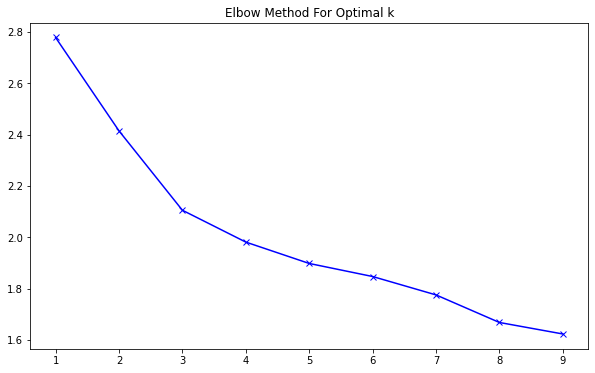

In [778]:
madrid_grouped_clustering = madrid_grouped.drop('Neighbourhood', 1)
sum_of_squared_distances = []
K = range(1,10)

for k in K:
    print(k, end=' ')
    kmeans = KMeans(n_clusters=k, random_state=100, n_init=20).fit(madrid_grouped_clustering)
    sum_of_squared_distances.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.title('Elbow Method For Optimal k')

__Clustering neighbourhoods__

Run _k_-means to cluster the neighbourhoods into 5 clusters.

In [779]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=100).fit(madrid_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 0, 3, 4, 1, 2, 0, 1, 1, 1], dtype=int32)

__Creating a dataframe with cluster labels and top venues__

In [780]:
# add clustering labels

neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
# neighbourhoods_venues_sorted['Cluster Labels'] = kmeans.labels_

madrid_merged = df_madrid

# merge madrid_grouped with df_madrid to add latitude/longitude for each neighbourhood
madrid_merged = madrid_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

madrid_merged.head()

,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,PALACIO,40.41517,-3.71273,0,Church,Restaurant,Spanish Restaurant,Historic Site,Monument / Landmark,Mexican Restaurant,Office,Plaza,Bar,Beer Bar
1,EMBAJADORES,40.40803,-3.70067,1,Spanish Restaurant,Tapas Restaurant,Bar,Restaurant,Salon / Barbershop,Pizza Place,Coffee Shop,Theater,Food & Drink Shop,Residential Building (Apartment / Condo)
2,CORTES,40.41589,-3.69636,3,Spanish Restaurant,Office,Restaurant,Hotel,Tapas Restaurant,Event Space,Capitol Building,Building,Japanese Restaurant,Embassy / Consulate
3,JUSTICIA,40.42479,-3.69308,3,Office,Art Gallery,Courthouse,Boutique,Embassy / Consulate,Restaurant,Post Office,Building,Food,Women's Store
4,UNIVERSIDAD,40.42565,-3.70726,0,Bookstore,Bar,Café,Hotel,Office,Hostel,Bed & Breakfast,Breakfast Spot,Metro Station,Mexican Restaurant


__Visualizing the clusters__

In [781]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, area, cluster in zip(madrid_merged['Latitude'], madrid_merged['Longitude'], madrid_merged['Neighbourhood'], madrid_merged['Cluster Labels']):
    label = folium.Popup(remove_accents(str(area)) + ' Cluster ' + str(cluster), parse_html=True)
    #print(f'lat:{lat} lon:{lon} area:{area} cluster:{cluster}')
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

__Examining clusters__

Let's find the residential clusters by examining the discriminating venue categories.

__Cluster 0__

In [782]:
madrid_merged.loc[madrid_merged['Cluster Labels'] == 0, madrid_merged.columns[[0] + list(range(4, madrid_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,PALACIO,Church,Restaurant,Spanish Restaurant,Historic Site,Monument / Landmark,Mexican Restaurant,Office,Plaza,Bar,Beer Bar
4,UNIVERSIDAD,Bookstore,Bar,Café,Hotel,Office,Hostel,Bed & Breakfast,Breakfast Spot,Metro Station,Mexican Restaurant
5,SOL,Clothing Store,Jewelry Store,Plaza,Accessories Store,Building,Hostel,Miscellaneous Shop,Office,Shoe Store,Salon / Barbershop
7,ACACIAS,Salon / Barbershop,Bank,Park,Non-Profit,Pizza Place,Medical Center,Pub,Tapas Restaurant,Fruit & Vegetable Store,Garden
18,NIÑO JESÚS,Office,Spanish Restaurant,Restaurant,Doctor's Office,Bank,Plaza,Government Building,Café,Medical Center,Sports Club
20,GOYA,Spanish Restaurant,Cosmetics Shop,Bank,Bus Line,Women's Store,Office,Bar,Jewelry Store,Shoe Store,Tapas Restaurant
21,FUENTE DEL BERRO,Spanish Restaurant,Office,Restaurant,Medical Center,Building,Doctor's Office,Speakeasy,Supermarket,Farmers Market,Bar
23,LISTA,Salon / Barbershop,Hospital,Bar,Pharmacy,Spanish Restaurant,Furniture / Home Store,Doctor's Office,Pet Store,Metro Station,Supermarket
26,PROSPERIDAD,Office,Dentist's Office,Spanish Restaurant,Salon / Barbershop,Restaurant,Tapas Restaurant,Bar,Cosmetics Shop,Cocktail Bar,Plaza
28,HISPANOAMÉRICA,Grocery Store,Bank,Pharmacy,Office,Gourmet Shop,Restaurant,Spanish Restaurant,Doctor's Office,Fish Market,Cosmetics Shop


__Cluster 1__

In [783]:
madrid_merged.loc[madrid_merged['Cluster Labels'] == 1, madrid_merged.columns[[0] + list(range(4, madrid_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,EMBAJADORES,Spanish Restaurant,Tapas Restaurant,Bar,Restaurant,Salon / Barbershop,Pizza Place,Coffee Shop,Theater,Food & Drink Shop,Residential Building (Apartment / Condo)
6,IMPERIAL,Bar,Office,Laundry Service,Residential Building (Apartment / Condo),Spanish Restaurant,Bank,School,Bus Stop,Cocktail Bar,Building
8,CHOPERA,Bar,Tapas Restaurant,Restaurant,Breakfast Spot,Plaza,Spanish Restaurant,Convenience Store,School,Coworking Space,Coffee Shop
11,PALOS DE MOGUER,Bank,Salon / Barbershop,Spanish Restaurant,Restaurant,Grocery Store,Bar,Gym,Pizza Place,Office,Supermarket
13,PACÍFICO,Bar,Medical Center,Grocery Store,Office,Bank,Salon / Barbershop,Event Space,Nail Salon,General Entertainment,Diner
15,ESTRELLA,Bar,Salon / Barbershop,Bank,Grocery Store,Coffee Shop,Office,Spanish Restaurant,School,General Entertainment,Building
16,IBIZA,Tapas Restaurant,Bank,Bar,Pizza Place,Salon / Barbershop,Bakery,Grocery Store,Kids Store,Brewery,Spanish Restaurant
31,BELLAS VISTAS,Bar,Spanish Restaurant,Smoke Shop,Grocery Store,Café,Coffee Shop,Martial Arts School,General Entertainment,Residential Building (Apartment / Condo),Deli / Bodega
32,CUATRO CAMINOS,Restaurant,Office,Japanese Restaurant,Bakery,Dentist's Office,Tapas Restaurant,Bank,Bar,Park,Spa
35,VALDEACEDERAS,Salon / Barbershop,Office,Spanish Restaurant,Bar,Medical Center,Breakfast Spot,Student Center,Residential Building (Apartment / Condo),Grocery Store,Athletics & Sports


__Cluster 2__

In [784]:
madrid_merged.loc[madrid_merged['Cluster Labels'] == 2, madrid_merged.columns[[0] + list(range(4, madrid_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
17,LOS JERÓNIMOS,Office,Art Gallery,Non-Profit,Restaurant,Café,Coworking Space,Building,Cocktail Bar,Coffee Shop,Museum
24,CASTELLANA,Office,Bank,Building,Flower Shop,Restaurant,Pharmacy,Bar,Financial or Legal Service,Men's Store,Café
27,CIUDAD JARDÍN,Office,Tech Startup,Pharmacy,Café,Building,Restaurant,Bus Stop,Other Great Outdoors,Tapas Restaurant,Japanese Restaurant
29,NUEVA ESPAÑA,Office,Medical Center,Dentist's Office,Building,Coworking Space,Embassy / Consulate,Student Center,Other Great Outdoors,General Entertainment,Deli / Bodega
30,CASTILLA,Office,Coworking Space,Bank,Building,Coffee Shop,Medical Center,General Entertainment,Pool,Tech Startup,Spanish Restaurant
33,CASTILLEJOS,Office,Bank,Residential Building (Apartment / Condo),Coworking Space,Spanish Restaurant,Restaurant,Gym,Italian Restaurant,Building,Miscellaneous Shop
40,ALMAGRO,Office,Building,Spanish Restaurant,Residential Building (Apartment / Condo),Business Center,Tech Startup,Professional & Other Places,Nightclub,Restaurant,Modern European Restaurant
56,EL PLANTÍO,Office,Coworking Space,Building,Boutique,Gas Station,Clothing Store,Spanish Restaurant,Nail Salon,Jewelry Store,Mediterranean Restaurant
93,QUINTANA,Office,Furniture / Home Store,Building,Gas Station,Restaurant,Factory,Bank,Automotive Shop,Other Great Outdoors,Grocery Store
118,SIMANCAS,Office,Building,Sandwich Place,Other Great Outdoors,Tech Startup,Coworking Space,Fast Food Restaurant,Gastropub,Coffee Shop,Car Wash


__Cluster 3__

In [785]:
madrid_merged.loc[madrid_merged['Cluster Labels'] == 3, madrid_merged.columns[[0] + list(range(4, madrid_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,CORTES,Spanish Restaurant,Office,Restaurant,Hotel,Tapas Restaurant,Event Space,Capitol Building,Building,Japanese Restaurant,Embassy / Consulate
3,JUSTICIA,Office,Art Gallery,Courthouse,Boutique,Embassy / Consulate,Restaurant,Post Office,Building,Food,Women's Store
9,LEGAZPI,Office,Residential Building (Apartment / Condo),Bus Line,General Entertainment,Pharmacy,Spanish Restaurant,Supermarket,Grocery Store,Pizza Place,Bar
10,DELICIAS,Office,Coffee Shop,Automotive Shop,Gym / Fitness Center,Gym,Restaurant,Building,Dive Bar,Medical Center,Design Studio
12,ATOCHA,Office,Train Station,Coffee Shop,Bank,Breakfast Spot,Building,Coworking Space,Residential Building (Apartment / Condo),Sushi Restaurant,Diner
14,ADELFAS,Office,Residential Building (Apartment / Condo),Pharmacy,Bank,Bar,Salon / Barbershop,Spanish Restaurant,Bakery,Coffee Shop,Automotive Shop
19,RECOLETOS,Boutique,Office,Cosmetics Shop,Clothing Store,Jewelry Store,Shoe Store,Bar,Men's Store,Café,Coworking Space
22,GUINDALERA,Office,Spanish Restaurant,Bar,Residential Building (Apartment / Condo),Bank,Automotive Shop,General Entertainment,Plaza,Nail Salon,Medical Center
25,EL VISO,Office,Embassy / Consulate,Bar,Tech Startup,Government Building,Bus Station,Salon / Barbershop,High School,Student Center,Spanish Restaurant
41,RÍOS ROSAS,Office,Tapas Restaurant,Japanese Restaurant,Government Building,Parking,Restaurant,Spanish Restaurant,Tech Startup,Italian Restaurant,Breakfast Spot


__Cluster 4__

In [786]:
madrid_merged.loc[madrid_merged['Cluster Labels'] == 4, madrid_merged.columns[[0] + list(range(4, madrid_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
127,AEROPUERTO,Airport Gate,Airport Service,Rental Car Location,Accessories Store,Coworking Space,Restaurant,Office,Sandwich Place,Transportation Service,Newsstand


__Selecting a cluster__

By exploring the most frequent venues of each of the five clusters we can describe the clusters as follows:

| Cluster | Type of area |
| :------ | :----------: |
|  0      | Business     |
|  1      | Recreation   |
|  2      | Residential  |
|  3      | Forest       |
|  4      | Airport      |

Therefore we will deeply analyse the cluster 2 since...

This cluster is the largest one and contains 64 neighbourhoods.

In [787]:
# From now on, work only with residential neighbourhoods
residential_cluster_id = 2
df_madrid_residential = df_madrid[df_madrid['Neighbourhood'].isin(madrid_merged.loc[madrid_merged['Cluster Labels'] == residential_cluster_id, 'Neighbourhood'])]

__Counting supermarkets in residential neighbourhoods__

In [788]:
food_drink_store = '4bf58dd8d48988d1f9941735'
market = '50be8ee891d4fa8dcc7199a7'
big_box_store = '52f2ab2ebcbc57f1066b8b42'
convenience_store = '4d954b0ea243a5684a65b473'
categories = food_drink_stores + ',' + market + ',' + big_box_store + ',' + convenience_store

supermarket_category = '52f2ab2ebcbc57f1066b8b46'

# Function to count the number of market-like venues in a given neighbourhood
def getMarketVenues(row):
    
    # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        row['Latitude'], 
        row['Longitude'],
        supermarket_category,
        radius, 
        LIMIT)

    # make the GET request and get get length of venues
    count = len(requests.get(url).json()["response"]['venues'])
    
    print(row['Neighbourhood'], str(count))

    # return count
    return pd.Series(count)

__Run the above function on each residential neighbourhood__

In [789]:
df_madrid_residential['Number of Markets'] = df_madrid_residential.apply(getMarketVenues, axis=1)
df_madrid_residential.head()

LOS JERÓNIMOS 22
LOS JERÓNIMOS 22
CASTELLANA 35
CIUDAD JARDÍN 23
NUEVA ESPAÑA 8
CASTILLA 7
CASTILLEJOS 26
ALMAGRO 33
EL PLANTÍO 0
QUINTANA 0
SIMANCAS 7
REJAS 3


<ipython-input-789-ce0a3f624f10>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_madrid_residential['Number of Markets'] = df_madrid_residential.apply(getMarketVenues, axis=1)


,Neighbourhood,Latitude,Longitude,Number of Markets
17,LOS JERÓNIMOS,40.41407,-3.69023,22
24,CASTELLANA,40.43494,-3.68319,35
27,CIUDAD JARDÍN,40.45046,-3.66771,23
29,NUEVA ESPAÑA,40.46412,-3.67980,8
30,CASTILLA,40.47131,-3.67600,7


### Census analysis <a class="anchor" id="census-analysis"></a>

__Merge dataframes__

In [879]:
pd.set_option('display.max_rows',200) 
#df_madrid[['Neighbourhood']]
df_madrid

,Neighbourhood,Latitude,Longitude
0,PALACIO,40.41517,-3.71273
1,EMBAJADORES,40.40803,-3.70067
2,CORTES,40.41589,-3.69636
3,JUSTICIA,40.42479,-3.69308
4,UNIVERSIDAD,40.42565,-3.70726
5,SOL,40.41802,-3.70577
6,IMPERIAL,40.40833,-3.71865
7,ACACIAS,40.40137,-3.70669
8,CHOPERA,40.39536,-3.69833
9,LEGAZPI,40.38702,-3.68990


In [804]:
print(df_madrid_residential.shape)
df_madrid_residential.head()

(11, 4)


,Neighbourhood,Latitude,Longitude,Number of Markets
17,LOS JERÓNIMOS,40.41407,-3.69023,22
24,CASTELLANA,40.43494,-3.68319,35
27,CIUDAD JARDÍN,40.45046,-3.66771,23
29,NUEVA ESPAÑA,40.46412,-3.67980,8
30,CASTILLA,40.47131,-3.67600,7


In [805]:
print(df_madrid_income.shape)
df_madrid_income.head()

(131, 2)


,Neighbourhood,Income
0,PALACIO,34675
1,EMBAJADORES,25999
2,CORTES,34952
3,JUSTICIA,40314
4,UNIVERSIDAD,30701


In [806]:
print(df_madrid_population.shape)
df_madrid_population.head()

(131, 2)


,Neighbourhood,Population
0,PALACIO,23691
1,EMBAJADORES,47460
2,CORTES,10763
3,JUSTICIA,18179
4,UNIVERSIDAD,33527


__Left join with income dataframe__ 

In [807]:
backup_df_madrid = df_madrid_residential

In [813]:
df_madrid_residential = backup_df_madrid

In [814]:
df_madrid_residential = df_madrid_residential.merge(df_madrid_income, how='left', on='Neighbourhood')
print(df_madrid_residential.shape)
df_madrid_residential.head()

(11, 5)


,Neighbourhood,Latitude,Longitude,Number of Markets,Income
0,LOS JERÓNIMOS,40.41407,-3.69023,22,84955
1,CASTELLANA,40.43494,-3.68319,35,82811
2,CIUDAD JARDÍN,40.45046,-3.66771,23,43706
3,NUEVA ESPAÑA,40.46412,-3.67980,8,80248
4,CASTILLA,40.47131,-3.67600,7,54869


__Left join with population dataframe__ 

In [815]:
df_madrid_residential = df_madrid_residential.merge(df_madrid_population, how='left', on='Neighbourhood')
print(df_madrid_residential.shape)
df_madrid_residential.head()

(11, 6)


,Neighbourhood,Latitude,Longitude,Number of Markets,Income,Population
0,LOS JERÓNIMOS,40.41407,-3.69023,22,84955,7003
1,CASTELLANA,40.43494,-3.68319,35,82811,17209
2,CIUDAD JARDÍN,40.45046,-3.66771,23,43706,18775
3,NUEVA ESPAÑA,40.46412,-3.67980,8,80248,24834
4,CASTILLA,40.47131,-3.67600,7,54869,17250


__Calculate proportion of markets__

Find how many people per one market live in each residential neighbourhood

In [816]:
backup_df_madrid = df_madrid_residential

In [822]:
df_madrid_residential = backup_df_madrid

In [823]:
df_madrid_residential['People per Market'] = df_madrid_residential.apply(lambda x: (x['Population'] // x['Number of Markets']) if x['Number of Markets'] > 0 else x['Population'], axis=1)
print(df_madrid_residential.shape)
df_madrid_residential

(11, 7)


,Neighbourhood,Latitude,Longitude,Number of Markets,Income,Population,People per Market
0,LOS JERÓNIMOS,40.41407,-3.69023,22,84955,7003,318
1,CASTELLANA,40.43494,-3.68319,35,82811,17209,491
2,CIUDAD JARDÍN,40.45046,-3.66771,23,43706,18775,816
3,NUEVA ESPAÑA,40.46412,-3.67980,8,80248,24834,3104
4,CASTILLA,40.47131,-3.67600,7,54869,17250,2464
5,CASTILLEJOS,40.45946,-3.69482,26,45025,20666,794
6,ALMAGRO,40.43296,-3.69153,33,68786,19742,598
7,EL PLANTÍO,40.46893,-3.82061,0,101419,2884,2884
8,QUINTANA,40.47229,-3.50976,0,30421,24903,24903
9,SIMANCAS,40.43577,-3.62488,7,31368,28731,4104


__Scatter plot with income vs people per market__

In [859]:

def scatter_text(x, y, text_column, data, title, xlabel, ylabel):
    """Scatter plot with country codes on the x y coordinates
       Based on this answer: https://stackoverflow.com/a/54789170/2641825"""
    # Create the scatter plot
    p1 = sns.scatterplot(x, y, data=data, size=8, legend=False)
    # Add text besides each point
    for line in range(0,data.shape[0]):
         p1.text(data[x][line]+100, data[y][line]+100, 
                 data[text_column][line], horizontalalignment='left', 
                 size='large', color='blue')
    # Set title and axis labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    return p1

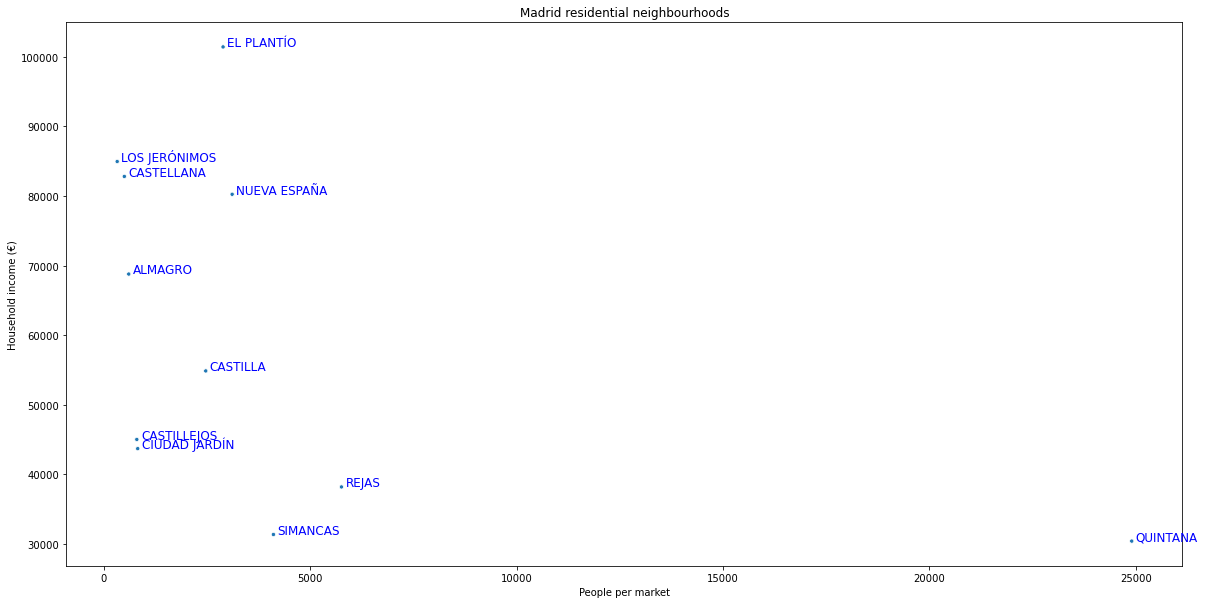

In [860]:
plt.figure(figsize=(20,10))
scatter_text('People per Market', 'Income', 'Neighbourhood',
             data = df_madrid_residential, 
             title = 'Madrid residential neighbourhoods', 
             xlabel = 'People per market',
             ylabel = 'Household income (€)')

## Results and discussion <a class="anchor" id="results-and-discussion"></a>

## Conclusion <a class="anchor" id="conclusion"></a>